In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from tabulate import tabulate
from tkinter import Tk, filedialog, simpledialog, messagebox
import statsmodels.api as sm
import BiQ_Common_Fxns as BiQ
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

c:\Users\ChrisSaid\anaconda3\envs\BiQ_env_20231205\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\ChrisSaid\anaconda3\envs\BiQ_env_20231205\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


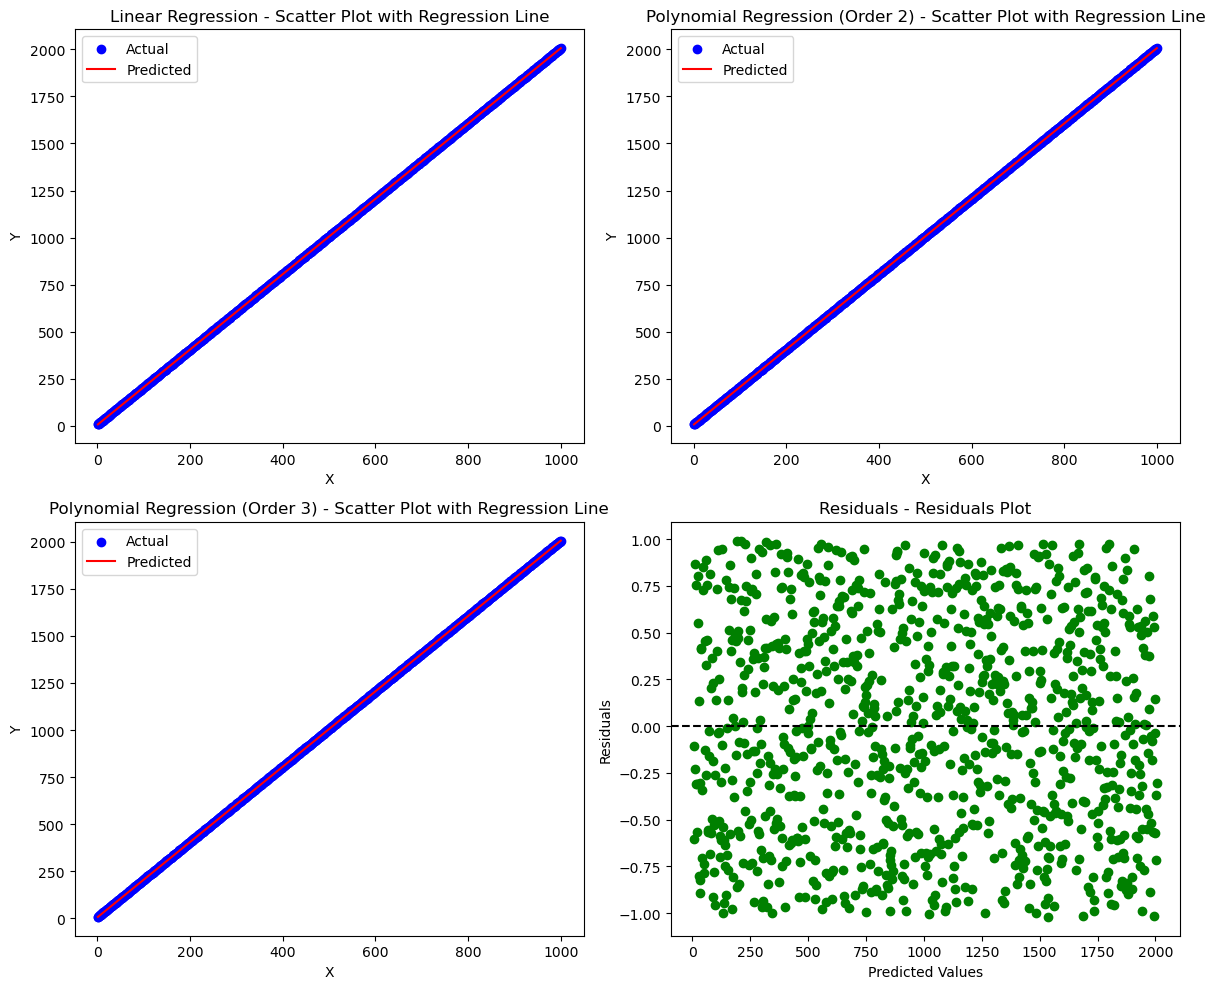


Linear Regression Coefficients:
+---------------+------------+--------------+-----------+---------+
| Coefficient   |   Estimate |   Std. Error |   t value |   P>|t| |
+===============+============+==============+===========+=========+
| const         |      6.003 |        0.036 |   164.492 |       0 |
+---------------+------------+--------------+-----------+---------+
| Ind           |      2     |        0     | 31663.8   |       0 |
+---------------+------------+--------------+-----------+---------+

Polynomial Regression (Order 2) Coefficients:
+---------------+------------+--------------+-----------+---------+
| Coefficient   |   Estimate |   Std. Error |   t value |   P>|t| |
+===============+============+==============+===========+=========+
| const         |      5.918 |        0.055 |   108.156 |   0     |
+---------------+------------+--------------+-----------+---------+
| x1            |      2.001 |        0     |  7923.66  |   0     |
+---------------+------------+------

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tkinter import Tk, filedialog
from tabulate import tabulate

def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    try:
        df = pd.read_excel(file_path)
        df = df.dropna(axis=1, how='all')
        return df
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None

def get_user_column_selection(df, title):
    """Gets user input for selecting a column using dialog boxes."""
    columns = df.columns.tolist()

    while True:
        col_name = input(f"Enter the column name for {title}:\nAvailable columns: {', '.join(columns)}\n")
        if col_name in columns:
            return col_name
        else:
            print(f"Column '{col_name}' not found in the DataFrame.")

def fit_linear_regression(df, x_col, y_col):
    """Fit a linear regression model."""
    X = df[[x_col]]
    X = sm.add_constant(X)  # Add constant for intercept
    y = df[y_col]

    model = sm.OLS(y, X).fit()
    return model

def fit_polynomial_regression(df, x_col, y_col, degree):
    """Fit a polynomial regression model."""
    X = df[[x_col]]
    y = df[y_col]

    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    model = sm.OLS(y, X_poly).fit()
    return model, polynomial_features, X_poly  # Return X_poly along with model and polynomial features


def calculate_regression_stats(model, X, y):
    """Calculate regression statistics."""
    if hasattr(model, 'predict'):
        X = sm.add_constant(X)  # Add constant for linear regression
    else:
        print("Model does not have a predict method.")
        return None

    y_pred = model.predict(X)
    residuals = y - y_pred
    n = len(y)
    p = X.shape[1] - 1

    sse = np.sum(residuals**2)
    sst = np.sum((y - np.mean(y))**2)

    r_squared = 1 - (sse / sst)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p - 1))
    std_err = np.sqrt(sse / (n - p - 1))

    return r_squared, adj_r_squared, std_err, n


def plot_regression(model, X, y, title, axes, poly_features=None):
    """Plot regression results."""
    feature_col = X.columns[0]
    X_feature = X[feature_col].values.reshape(-1, 1)  # Convert X to numpy array

    if hasattr(model, 'params'):
        if poly_features is not None:
            X_poly = poly_features.transform(X_feature)  # Transform X_feature
        else:
            X_poly = X_feature  # Use X_feature directly if poly_features is None

        axes.scatter(X_feature[:, 0], y, color='blue', label='Actual')
        y_pred = model.predict(sm.add_constant(X_poly))  # Add constant for linear regression
        axes.plot(X_feature[:, 0], y_pred, color='red', label='Predicted')
        axes.set_title(f'{title} - Scatter Plot with Regression Line')
        axes.set_xlabel('X')
        axes.set_ylabel('Y')
        axes.legend()
    else:
        axes.scatter(X_feature[:, 0], y, color='blue', label='Actual')
        axes.plot(X_feature[:, 0], model.predict(sm.add_constant(X_feature)), color='red', label='Predicted')
        axes.set_title(f'{title} - Scatter Plot with Regression Line')
        axes.set_xlabel('X')
        axes.set_ylabel('Y')
        axes.legend()

def plot_residuals(model, X, y, title, axes):
    """Plot residuals."""
    if hasattr(model, 'predict'):
        if isinstance(X, pd.DataFrame):
            X = X.values  # Convert DataFrame to numpy array
        y_pred = model.predict(sm.add_constant(X))  # Add constant for linear regression
    elif hasattr(model, 'predict_proba'):
        if isinstance(X, pd.DataFrame):
            X = X.values  # Convert DataFrame to numpy array
        y_pred = model.predict_proba(sm.add_constant(X))[:, 1]
    else:
        print("Model does not have a predict or predict_proba method.")
        return

    residuals = y - y_pred
    axes.scatter(y_pred, residuals, color='green')
    axes.axhline(y=0, color='black', linestyle='--')
    axes.set_title(f'{title} - Residuals Plot')
    axes.set_xlabel('Predicted Values')
    axes.set_ylabel('Residuals')


def main():
    root = Tk()
    root.withdraw()  
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
    if not file_path:
        print("No file selected.")
        return

    df = read_excel_file(file_path)
    if df is None:
        print("Error reading Excel file.")
        return

    x_col = get_user_column_selection(df, "Independent Variable (X)")
    if x_col is None:
        print("Error: Invalid input for independent variable.")
        return

    y_col = get_user_column_selection(df, "Dependent Variable (Y)")
    if y_col is None:
        print("Error: Invalid input for dependent variable.")
        return

    linear_model = fit_linear_regression(df, x_col, y_col)
    poly2_model, poly2_features, X_poly2 = fit_polynomial_regression(df, x_col, y_col, degree=2)
    poly3_model, poly3_features, X_poly3 = fit_polynomial_regression(df, x_col, y_col, degree=3)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    plot_regression(linear_model, df[[x_col]], df[y_col], "Linear Regression", axs[0, 0])
    plot_regression(poly2_model, df[[x_col]], df[y_col], "Polynomial Regression (Order 2)", axs[0, 1], poly2_features)
    plot_regression(poly3_model, df[[x_col]], df[y_col], "Polynomial Regression (Order 3)", axs[1, 0], poly3_features)
    plot_residuals(linear_model, df[[x_col]], df[y_col], "Residuals", axs[1, 1])

    plt.tight_layout()
    plt.show()

    models = {
        'Linear Regression': (linear_model, None),  # No features for linear regression
        'Polynomial Regression (Order 2)': (poly2_model, poly2_features),
        'Polynomial Regression (Order 3)': (poly3_model, poly3_features),
    }

    coef_data = []

    for model_name, (model, features) in models.items():
        coef_results = []  # Initialize coef_results for each model
        X = df[[x_col]] if features is None else features.transform(df[[x_col]])
        y = df[y_col]
        regression_stats = calculate_regression_stats(model, X, y)  # Calculate regression stats
        coef_names = model.params.index.tolist()  # Get coefficient names

        for coef_name, coef_value, std_err, t_value, p_value in zip(
            model.params.index, model.params.values, model.bse.values, model.tvalues.values,
            model.pvalues.values
        ):
            coef_results.append([coef_name, coef_value.round(3), std_err.round(3),
                                t_value.round(3), p_value.round(3)])

        coef_data.append([model_name] + coef_results)

    # Print Coefficients Table
    for model_coef_data in coef_data:
        print(f"\n{model_coef_data[0]} Coefficients:")
        print(tabulate(model_coef_data[1:], headers=["Coefficient", "Estimate", "Std. Error",
                                                     "t value", "P>|t|"],
                       tablefmt="grid"))

    # Print regression statistics
    stats_data = []
    for model_name, (model, features) in models.items():
        X = df[[x_col]]
        X_const = sm.add_constant(X) if 'Linear' in model_name else features.fit_transform(X)
        y = df[y_col]

        stats = calculate_regression_stats(model, X_const, y)
        stats_data.append([model_name] + list(stats))

    # Print Summary Statistics Table
    print("\nRegression Statistics:")
    print(tabulate(stats_data, headers=["Model", "R Square", "Adjusted R Square", "Standard Error", "Number of Observations"], tablefmt="grid"))

if __name__ == "__main__":
    main()

